In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import time

In [6]:
#Functions

#Interaction Kernel for Opinion Dynamics
def interaction_function(r):
    if (0 <= r < (1/np.sqrt(2))):
        return 1
    elif ((1/np.sqrt(2)) <= r < 1):
        return 0.1
    else:
        return 0

#Velocity Calculation Function
def compute_velocity(positions, interaction_function):
    N = len(positions)
    velocity = np.zeros_like(positions)
    for i in range(N):
        sum_term = np.zeros_like(positions[i])
        for j in range(N):
            if i != j:
                r = positions[j] - positions[i]
                distance = np.linalg.norm(r)
                phi = interaction_function(distance)
                sum_term += phi * r
        velocity[i] = sum_term / N
    return velocity

#Simple Visualization Function
def plot_agent_paths(x, xlim = (0, 10), ylim = (0, 10)):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()

    if dim == 1:
        x_values = np.linspace(t_span[0], t_span[1], t_steps)
        for agent in range(N):
            ax.plot(x_values, x[:, agent, 0], c = 'blue')
        plt.xlim(t_span[0], t_span[1])
        plt.xlabel('Time')
        plt.ylabel('X Value')
    elif dim == 2:
        for agent in range(N):
            ax.plot(x[:, agent, 0], x[:, agent, 1], c = 'blue')
        for agent in x[len(x)-1]:
            plt.scatter(agent[0], agent[1], c = 'blue', s = 5)
        plt.xlim(xlim)
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
    else:
        print('Dimension Invalid')
        
    plt.ylim(ylim)
    plt.savefig('recent_trajectory.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

def generate_trajectory(dim, N, t_span, t_steps, interaction_function = interaction_function, xlim = (0, 10), ylim = (0, 10)):
    x = np.random.uniform(xlim[0], xlim[1], (N, dim))  # Initial positions based on dimension
    steps = np.arange(0, t_steps, 1) #time step array
    position_log = np.zeros((t_steps, N, dim)) #log of positions for each time step for visualization

    #Euler's Method Position Calculations
    for step in steps:
        position_log[step] = x
        x += compute_velocity(x, interaction_function) * (t_span[1]/t_steps)

    return position_log

In [7]:
#Initial Conditions and Setup
dim = 1 #dimension for simulation
N = 50 #number of agents
t_span = (0, 10) #Time span for the simulation
t_steps = 200 #Number of simulation steps within the time span
xlim = (0, 10)
ylim = (0, 10)

In [8]:
#Save starting time
start_time = time.time()

#Generate Trajectory Data
num_trajectories = 10
trajectories = []

for i in range(num_trajectories):
    trajectories.append(generate_trajectory(dim, N, t_span, t_steps))

#Output computation time for this section
traj_time = time.time()
print(f'Trajectory Computation Time: {traj_time-start_time}')

Trajectory Computation Time: 74.7205982208252


In [9]:
#Calculating distances for all patricles at all 
#Generates 3D array of pairwise distances between particles at each time step
def calculate_distances(positions):
    num_particles = positions.shape[1]
    num_time_steps = positions.shape[0]
    distances = np.zeros((num_time_steps, num_particles, num_particles))
    
    for t in range(num_time_steps):
        for i in range(num_particles):
            for j in range(num_particles):
                distances[t, i, j] = np.linalg.norm(positions[t, i] - positions[t, j])
    
    return distances

#Finds R_min and R_max using CDF
def determine_r_min_max (distances, threshold):
    distances = distances.flatten()
    hist, bin_edges = np.histogram(distances, bins='auto', density=True) #create histogram from distances
    cdf = np.cumsum(hist * np.diff(bin_edges)) #find cumulative distribution function
    R_min = bin_edges[np.searchsorted(cdf, threshold)]
    R_max = bin_edges[np.searchsorted(cdf, 1 - threshold)]
    
    return R_min, R_max

#creates basis functions based on R range
def piecewise_polynomial_basis(degree, R_min, R_max, num_intervals):
    intervals = np.linspace(R_min, R_max, num_intervals + 1)
    basis_functions = []
    #loop through intervals creating a basis function for each interval
    for i in range(num_intervals):
        def basis_function(x, a=intervals[i], b=intervals[i+1], degree=degree):
            coefficients = np.polyfit(np.linspace(a, b, degree + 1), np.linspace(0, 1, degree + 1), degree)
            return np.polyval(coefficients, x)
        basis_functions.append(basis_function)
    return basis_functions

def piecewise_constant_basis(R_min, R_max, num_intervals):
    intervals = np.linspace(R_min, R_max, num_intervals+1)
    basis_functions = []
    for i in range(num_intervals):
        def basis_function(x, a=intervals[i], b=intervals[i+1], degree = degree):
            if a > 1:
                output = 0
            else:
                output = 0.5 * (a <= x < b)
            return output #returns 0.5 for values within the interval selected
        basis_functions.append(basis_function)
    return basis_functions
    
#Generate Learning Matrix
#Uses distances and basis functions to genereate a representative matrix that encompasses all pairwise distances for all particles at all time steps
def construct_learning_matrix(distances, basis_functions):
    num_time_steps, num_particles, _ = distances.shape
    num_basis_functions = len(basis_functions)
    
    # Initialize the learning matrix
    learning_matrix = np.zeros((num_time_steps * num_particles, num_basis_functions))

    #Applys the basis functions to each distance for each particle at each time step to fill the matrix
    for t in range(num_time_steps):
        for i in range(num_particles):
            for p, func in enumerate(basis_functions):
                sum_terms = 0
                for j in range(num_particles):
                    #apply basis functions based on distance?
                    sum_terms += func(distances[t, i, j]) * distances[t, i, j] #Equation 15 from the Appendix
                learning_matrix[t * num_particles + i, p] = sum_terms / num_particles
    
    return learning_matrix

#Run functions
learning_matrices = []
basis_functions_list = []
degree = 1
num_intervals = 10 #how many different basis functions to create across the R range


for trajectory in trajectories:
    distances = calculate_distances(trajectory)
    R_min, R_max = determine_r_min_max(distances, 0.05)
    basis_functions = piecewise_constant_basis(R_min, R_max, num_intervals)
    basis_functions_list.append(basis_functions)
    learning_matrix = construct_learning_matrix(distances, basis_functions)
    learning_matrices.append(learning_matrix)

#Output computation time for this section
matrix_time = time.time()
print(f'Learning Matrix Computation Time: {matrix_time-start_time}')

Learning Matrix Computation Time: 308.8020293712616


In [10]:
#Instantiate A_L_m and b_L_m
def compute_regression_matrices(learning_matrix, observed_data, L, N): #Equation 16 from Appendix
    A_L_m = (1 / (L * N)) * np.dot(learning_matrix.T, learning_matrix)
    b_L_m = (1 / (L * N)) * np.dot(learning_matrix.T, observed_data.reshape(-1, 1))
    return A_L_m, b_L_m
    
A_matrices = []
b_vectors = []

for i in range(len(learning_matrices)):
    A_L_m, b_L_m = compute_regression_matrices(learning_matrices[i], trajectories[i].flatten(), t_steps, N)
    A_matrices.append(A_L_m)
    b_vectors.append(b_L_m)

#Output computation time for this section
regression_time = time.time()
print(f'Regression Matrix Computation Time: {regression_time-matrix_time}')

Regression Matrix Computation Time: 0.08171272277832031


In [11]:
#Solve Least Squares Problem
A_L = sum(A_matrices) / num_trajectories
b_L = sum(b_vectors) / num_trajectories
a_optimal, residuals, rank, s = np.linalg.lstsq(A_L, b_L, rcond=None) #Use Numpy function to optimize coefficients from A_L and b_L

#Generate predicted data using optimized coefficients
predicted_trajectories = []
mse_sum = 0
for i in range(len(learning_matrices)):
    predicted_data = np.dot(learning_matrices[i], a_optimal)
    predicted_trajectories.append(predicted_data)
    #Compare observed and predicted values to find MSE
    mse_sum += np.mean((trajectories[i].flatten() - predicted_data.flatten()) ** 2)

#Get average mean squared error for all trajectories
mse = mse_sum/(len(trajectories)*N*t_steps)
print('Mean Squared Error: ', mse)

#Output computation time for this section and total computation time
stop_time = time.time()
print(f'Error Calculation Time: {stop_time-regression_time}')
print(f'Total Computation Time: {stop_time-start_time}')

Mean Squared Error:  0.001208467512396281
Error Calculation Time: 0.03976941108703613
Total Computation Time: 308.92351150512695


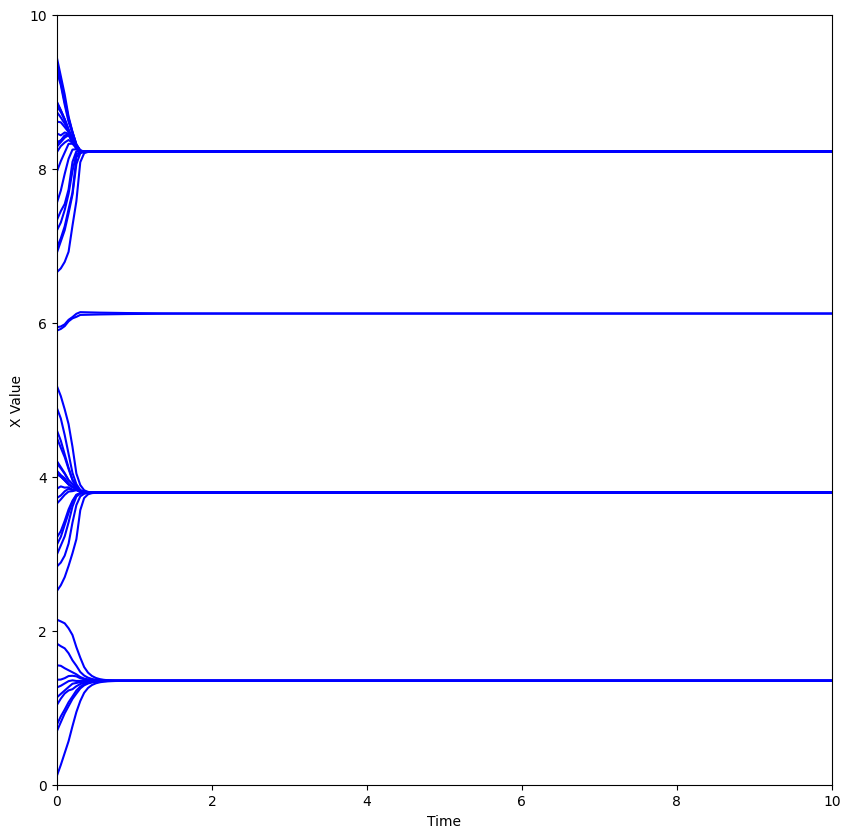

In [12]:
#Create new interaction function utilizing the new coefficients
def new_interaction_function(r, a_optimal = a_optimal):
    num_basis_funcs = len(basis_functions_list[0])
    coefs = a_optimal
    total = 0
    for i in range(num_basis_funcs):
        total += coefs[i]*basis_functions_list[0][i](r)
    return total
    
#Generate a test trajectory and plot using new interaction function
test_trajectory = generate_trajectory(dim, N, t_span, t_steps, new_interaction_function)
plot_agent_paths(test_trajectory)

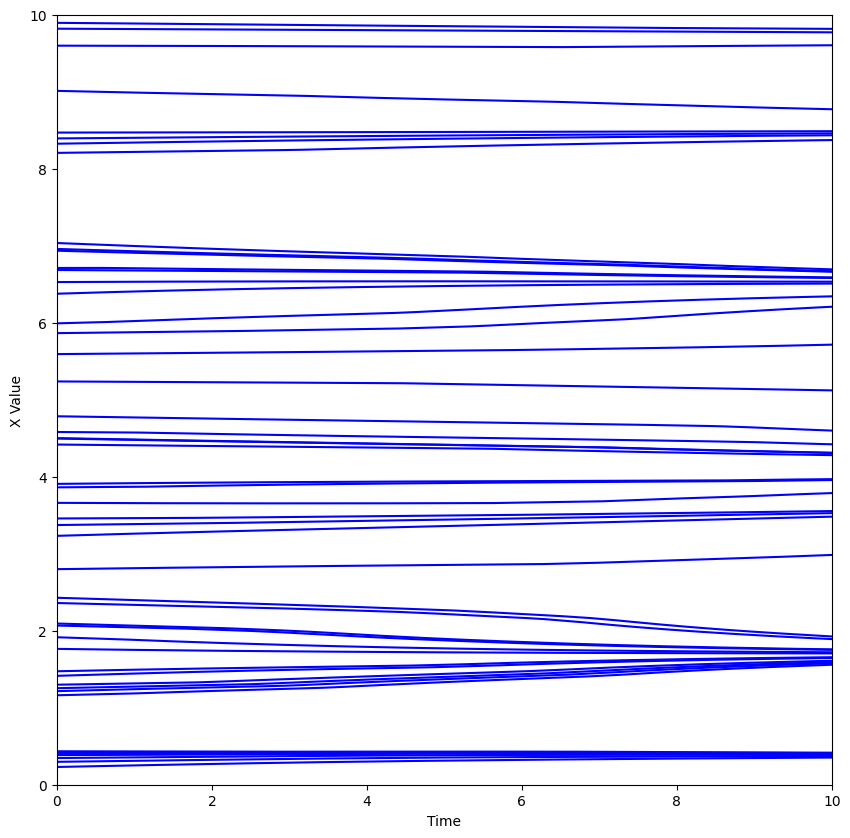

In [13]:
#Plot original trajectory for comparison
plot_agent_paths(trajectories[0])